Предварительная обработка данных

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('/content/gdrive/MyDrive/Khabarovsk_weather.csv', encoding='cp1251', sep=';')
df.head()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,LocalTime,T,P0,P,U,DD
0,15.10.2020 23:30,4.0,753.6,760.5,48.0,Ветер
1,15.10.2020 23:00,4.0,753.6,760.5,48.0,Ветер
2,15.10.2020 22:30,5.0,753.6,760.5,42.0,Ветер
3,15.10.2020 22:00,5.0,753.6,760.5,42.0,Ветер
4,15.10.2020 21:30,5.0,753.6,760.5,45.0,Ветер


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119674 entries, 0 to 119673
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   LocalTime  119674 non-null  object 
 1   T          119665 non-null  float64
 2   P0         119664 non-null  float64
 3   P          119667 non-null  float64
 4   U          119665 non-null  float64
 5   DD         119662 non-null  object 
dtypes: float64(4), object(2)
memory usage: 5.5+ MB


In [ ]:
df.isna().sum()

LocalTime     0
T             9
P0           10
P             7
U             9
DD           12
dtype: int64

In [ ]:
df = df.dropna()
df.isna().sum()

LocalTime    0
T            0
P0           0
P            0
U            0
DD           0
dtype: int64

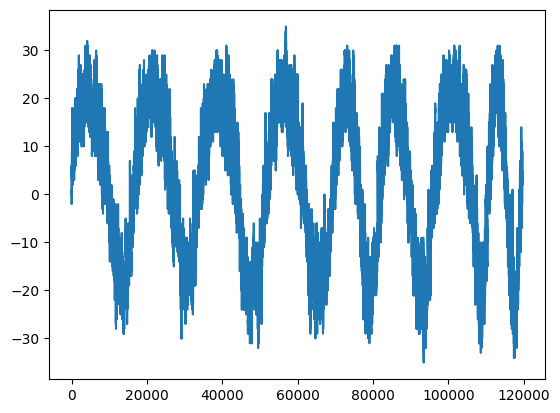

In [ ]:
# Визуализация температуры
plt.plot(range(1,len(df['T'].values)+1), df['T'].values)

In [ ]:
# Преобразование данных (скалирование)
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

data = df['T'].values
data = min_max_scaler.fit_transform(data.reshape(-1, 1))

print(data.shape)
data =data.flatten()
print(data.shape)

(119656, 1)
(119656,)


Выделение тестовой, тренировочной и валидационных выборок

In [ ]:
window = 15

n_samples=data.shape[0]-window
n_train_samples=round(0.7*n_samples)
n_val_samples=round(0.15*n_samples)
n_test_samples=n_samples-n_train_samples-n_val_samples
print('Train = ',n_train_samples,'Validation = ',n_val_samples,'Test = ',n_test_samples)

Train =  83749 Validation =  17946 Test =  17946


In [ ]:
# Выделение пустых массивов
X_train=np.zeros((n_train_samples,window))
y_train=np.zeros(n_train_samples)

X_val=np.zeros((n_val_samples,window))
y_val=np.zeros(n_val_samples)

X_test=np.zeros((n_test_samples,window))
y_test=np.zeros(n_test_samples)

# Тренировочная выборка
for i in range(n_train_samples):
  for j in range(window):
    X_train[i,j]=data[i+j]
  y_train[i]=data[i+window]

# Валидационная выборка
for i in range(n_val_samples):
  for j in range(window):
    X_val[i,j]=data[n_train_samples+i+j]
  y_val[i]=data[n_train_samples+i+window]

# Тестовая выборка
for i in range(n_test_samples):
  for j in range(window):
    X_test[i,j]=data[n_train_samples+n_val_samples+i+j]
  y_test[i]=data[n_train_samples+n_val_samples+i+window]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# Создание двухслойной нейронной сети с 10-ю нейронами в скрытом слое
ff_model=Sequential()
ff_model.add(Dense(10,activation='relu',input_dim=window))
ff_model.add(Dense(1))
ff_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                160       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 171 (684.00 Byte)
Trainable params: 171 (684.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
ff_model.compile(loss='mse',optimizer='adam',metrics='mae')

from keras.callbacks import ModelCheckpoint,EarlyStopping

# Ранняя остановка после 5 эпох без улучшений
early_stop = EarlyStopping(monitor='val_mae',patience=5,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/Lab2DL/ff-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

ff_model_history = ff_model.fit(X_train,y_train,batch_size=25,epochs=40,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/40
3334/3350 [============================>.] - ETA: 0s - loss: 2.0901e-04 - mae: 0.0108
Epoch 1: val_mae improved from inf to 0.01134, saving model to /content/gdrive/MyDrive/Lab2DL/ff-temperature-01-0.011.hdf5
3350/3350 [==============================] - 7s 2ms/step - loss: 2.0892e-04 - mae: 0.0108 - val_loss: 2.3612e-04 - val_mae: 0.0113
Epoch 2/40
  65/3350 [..............................] - ETA: 5s - loss: 1.9526e-04 - mae: 0.0105

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3342/3350 [============================>.] - ETA: 0s - loss: 1.8534e-04 - mae: 0.0102
Epoch 2: val_mae improved from 0.01134 to 0.01094, saving model to /content/gdrive/MyDrive/Lab2DL/ff-temperature-02-0.011.hdf5
3350/3350 [==============================] - 8s 2ms/step - loss: 1.8531e-04 - mae: 0.0102 - val_loss: 2.1605e-04 - val_mae: 0.0109
Epoch 3/40
3346/3350 [============================>.] - ETA: 0s - loss: 1.7286e-04 - mae: 0.0098
Epoch 3: val_mae improved from 0.01094 to 0.01072, saving model to /content/gdrive/MyDrive/Lab2DL/ff-temperature-03-0.011.hdf5
3350/3350 [==============================] - 7s 2ms/step - loss: 1.7285e-04 - mae: 0.0098 - val_loss: 2.0730e-04 - val_mae: 0.0107
Epoch 4/40
3331/3350 [============================>.] - ETA: 0s - loss: 1.6455e-04 - mae: 0.0095
Epoch 4: val_mae did not improve from 0.01072
3350/3350 [==============================] - 7s 2ms/step - loss: 1.6446e-04 - mae: 0.0095 - val_loss: 2.2565e-04 - val_mae: 0.0112
Epoch 5/40
3350/3350 [=====

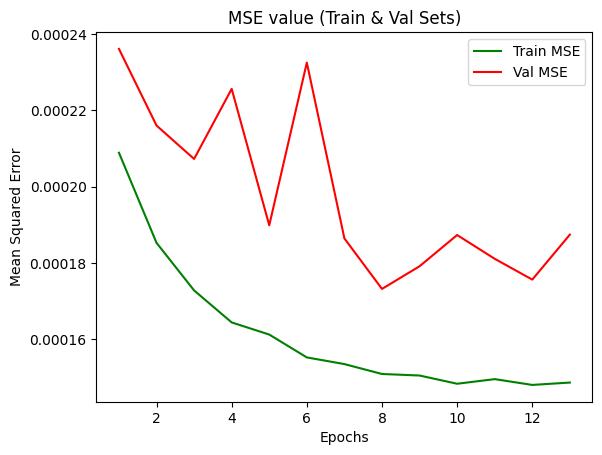

In [ ]:
# График обучения
loss_function = ff_model_history.history['loss']
val_loss_function = ff_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('MSE value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train MSE')
plt.plot(epochs,val_loss_function,color='red',label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error

ff_model.load_weights("/content/gdrive/MyDrive/Lab2DL/ff-temperature-08-0.009.hdf5")

y_pred = ff_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),'С degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))
print('MSE = ', round(mean_squared_error(y_true=y_test_inv, y_pred=y_pred_inv), 3))

561/561 [==============================] - 3s 4ms/step
MAE =  0.782 С degrees
R2-score =  0.995
MSE =  1.124


Сравнение настоящей температуры и температуры, предсказанной моделью

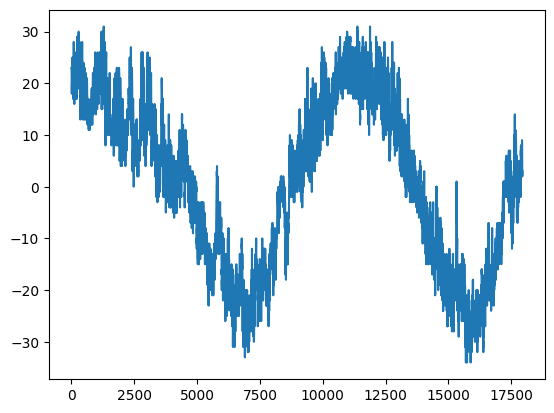

In [ ]:
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)

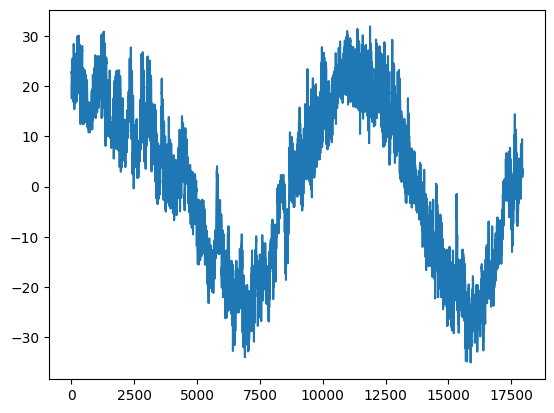

In [ ]:
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

RNN

In [ ]:
from keras.layers import SimpleRNN

simple_rnn_model = Sequential()
# Создание рекуррентной НС с 10ю нейронами, длиной последовательности window и 1 признаком на входе
simple_rnn_model.add(SimpleRNN(10,activation='relu',input_shape=(window,1)))
# Выходной слой с 1 нейроном и линейной активацией
simple_rnn_model.add(Dense(1,activation='linear'))

In [ ]:
# Согласование размерностей массивов
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

# Компиляция модели
simple_rnn_model.compile(loss='mse',optimizer='adam',metrics='mae')

from keras.callbacks import ModelCheckpoint,EarlyStopping
# Ранняя остановка после 5 эпох без изменений с минимизацией MAE
early_stop = EarlyStopping(monitor='val_mae',patience=5,mode='min',verbose=1)
checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/Lab2DL/RNN/simple_rnn-temperature-{epoch:02d}-{val_mae:.3f}.hdf5',
                              monitor='val_mae',verbose=1,mode='min',
                              save_best_only=True)
callbacks_list=[early_stop,checkpoint]

# Обучение модели
simple_rnn_model_history = simple_rnn_model.fit(X_train,y_train,batch_size=25,epochs=40,
                                callbacks=callbacks_list,
                                validation_data=(X_val,y_val))

Epoch 1/40
3349/3350 [============================>.] - ETA: 0s - loss: 1.5346e-04 - mae: 0.0091
Epoch 1: val_mae improved from inf to 0.00999, saving model to /content/gdrive/MyDrive/Lab2DL/RNN/simple_rnn-temperature-01-0.010.hdf5
3350/3350 [==============================] - 22s 6ms/step - loss: 1.5347e-04 - mae: 0.0091 - val_loss: 1.8443e-04 - val_mae: 0.0100
Epoch 2/40
  41/3350 [..............................] - ETA: 12s - loss: 1.5653e-04 - mae: 0.0087

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3347/3350 [============================>.] - ETA: 0s - loss: 1.4643e-04 - mae: 0.0088
Epoch 2: val_mae improved from 0.00999 to 0.00942, saving model to /content/gdrive/MyDrive/Lab2DL/RNN/simple_rnn-temperature-02-0.009.hdf5
3350/3350 [==============================] - 21s 6ms/step - loss: 1.4650e-04 - mae: 0.0088 - val_loss: 1.7447e-04 - val_mae: 0.0094
Epoch 3/40
3339/3350 [============================>.] - ETA: 0s - loss: 1.4530e-04 - mae: 0.0088
Epoch 3: val_mae improved from 0.00942 to 0.00926, saving model to /content/gdrive/MyDrive/Lab2DL/RNN/simple_rnn-temperature-03-0.009.hdf5
3350/3350 [==============================] - 20s 6ms/step - loss: 1.4525e-04 - mae: 0.0088 - val_loss: 1.7304e-04 - val_mae: 0.0093
Epoch 4/40
3343/3350 [============================>.] - ETA: 0s - loss: 1.4340e-04 - mae: 0.0087
Epoch 4: val_mae did not improve from 0.00926
3350/3350 [==============================] - 23s 7ms/step - loss: 1.4341e-04 - mae: 0.0087 - val_loss: 1.7129e-04 - val_mae: 0.0093


In [ ]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_error

simple_rnn_model.load_weights("/content/gdrive/MyDrive/Lab2DL/RNN/simple_rnn-temperature-10-0.009.hdf5")

y_pred = simple_rnn_model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

print('MAE = ',round(mean_absolute_error(y_true=y_test_inv,y_pred=y_pred_inv),3),'С degrees')
print('R2-score = ',round(r2_score(y_test_inv,y_pred_inv),3))
print('MSE = ', round(mean_squared_error(y_true=y_test_inv, y_pred=y_pred_inv), 3))

561/561 [==============================] - 6s 11ms/step
MAE =  0.746 С degrees
R2-score =  0.996
MSE =  1.06


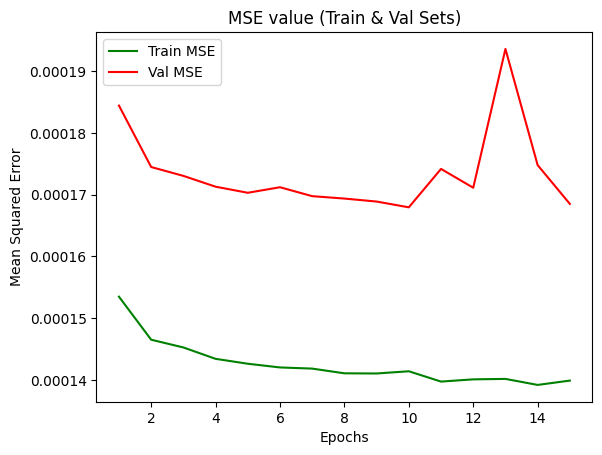

In [ ]:
# График обучения
loss_function = simple_rnn_model_history.history['loss']
val_loss_function = simple_rnn_model_history.history['val_loss']

epochs=range(1,len(loss_function)+1)

plt.title('MSE value (Train & Val Sets)')
plt.plot(epochs,loss_function,color='green',label='Train MSE')
plt.plot(epochs,val_loss_function,color='red',label='Val MSE')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

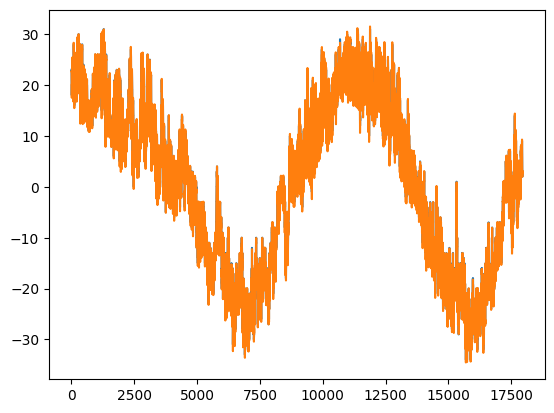

In [ ]:
# Наложенные друг на друга графики для сравнения
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,LSTM

model = Sequential()
# LSTM-регрессор с 10 нейронами (рамерность входных данных та же)
model.add(LSTM(10,input_shape=(window,1)))
model.add(Dense(1,activation='linear'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',loss='mse',metrics='mae')

# Обучение на 15-ти эпохах
history = model.fit(X_train,y_train,epochs=15,batch_size=32,
                    validation_data=(X_val,y_val))

Epoch 1/15
2618/2618 [==============================] - 29s 10ms/step - loss: 0.0031 - mae: 0.0281 - val_loss: 5.3395e-04 - val_mae: 0.0176
Epoch 2/15
2618/2618 [==============================] - 28s 11ms/step - loss: 3.1549e-04 - mae: 0.0134 - val_loss: 2.7731e-04 - val_mae: 0.0126
Epoch 3/15
2618/2618 [==============================] - 30s 11ms/step - loss: 1.8364e-04 - mae: 0.0101 - val_loss: 2.1851e-04 - val_mae: 0.0113
Epoch 4/15
2618/2618 [==============================] - 26s 10ms/step - loss: 1.5401e-04 - mae: 0.0092 - val_loss: 1.7383e-04 - val_mae: 0.0095
Epoch 5/15
2618/2618 [==============================] - 29s 11ms/step - loss: 1.4743e-04 - mae: 0.0089 - val_loss: 1.9710e-04 - val_mae: 0.0107
Epoch 6/15
2618/2618 [==============================] - 28s 11ms/step - loss: 1.4527e-04 - mae: 0.0088 - val_loss: 1.8358e-04 - val_mae: 0.0099
Epoch 7/15
2618/2618 [==============================] - 28s 11ms/step - loss: 1.4341e-04 - mae: 0.0088 - val_loss: 2.0171e-04 - val_mae: 0.0

561/561 [==============================] - 2s 3ms/step


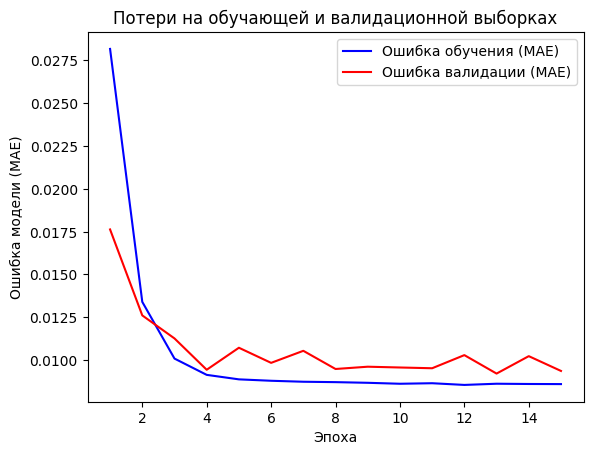

In [ ]:
# График обучения
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,mae,color='blue',label='Ошибка обучения (MAE)')
plt.plot(epochs,val_mae,color='red',label='Ошибка валидации (MAE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MAE)')
plt.legend()
plt.show()

In [ ]:
# Результаты работы модели
y_pred = model.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

print('R2 Score (Test) = ',round(r2_score(y_true=y_test_inv,y_pred=y_pred_inv),3))
print('MAE (Test) = ',round(mean_absolute_error(y_true=y_test_inv,
                                                     y_pred=y_pred_inv),3))
print('MSE (Test) = ', round(mean_squared_error(y_true=y_test_inv, y_pred=y_pred_inv), 3))

561/561 [==============================] - 2s 3ms/step
R2 Score (Test) =  0.996
MAE (Test) =  0.763
MSE (Test) =  1.066


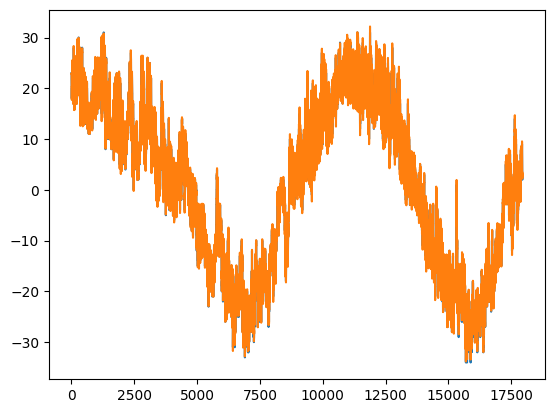

In [ ]:
# Наложенные графики для сравнения
# Синий цвет - оригинальные точки
# Оранжевый - предсказанные
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)

Регрессор – стек двух слоёв с LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model2LTMS = Sequential()
model2LTMS.add(LSTM(10, return_sequences=True, input_shape=(window, 1)))
model2LTMS.add(LSTM(5))  # Второй слой LSTM

model2LTMS.add(Dense(1, activation='linear'))  # Выходной слой для задачи регрессии

model2LTMS.summary()  # Для вывода описания структуры модели

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 15, 10)            480       
                                                                 
 lstm_3 (LSTM)               (None, 5)                 320       
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 806 (3.15 KB)
Trainable params: 806 (3.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model2LTMS.compile(optimizer='adam',loss='mse',metrics='mae')

# Обучение на 10-ти эпохах
history = model2LTMS.fit(X_train,y_train,epochs=10,batch_size=32,
                    validation_data=(X_val,y_val))

Epoch 1/10
2618/2618 [==============================] - 56s 19ms/step - loss: 6.0042e-04 - mae: 0.0178 - val_loss: 2.8642e-04 - val_mae: 0.0126
Epoch 2/10
2618/2618 [==============================] - 47s 18ms/step - loss: 2.1204e-04 - mae: 0.0109 - val_loss: 2.0950e-04 - val_mae: 0.0106
Epoch 3/10
2618/2618 [==============================] - 49s 19ms/step - loss: 1.6484e-04 - mae: 0.0095 - val_loss: 1.9148e-04 - val_mae: 0.0103
Epoch 4/10
2618/2618 [==============================] - 48s 19ms/step - loss: 1.5017e-04 - mae: 0.0090 - val_loss: 2.2915e-04 - val_mae: 0.0116
Epoch 5/10
2618/2618 [==============================] - 47s 18ms/step - loss: 1.4657e-04 - mae: 0.0089 - val_loss: 1.7277e-04 - val_mae: 0.0097
Epoch 6/10
2618/2618 [==============================] - 46s 17ms/step - loss: 1.4511e-04 - mae: 0.0088 - val_loss: 1.6869e-04 - val_mae: 0.0092
Epoch 7/10
2618/2618 [==============================] - 46s 18ms/step - loss: 1.4470e-04 - mae: 0.0088 - val_loss: 1.8155e-04 - val_mae:

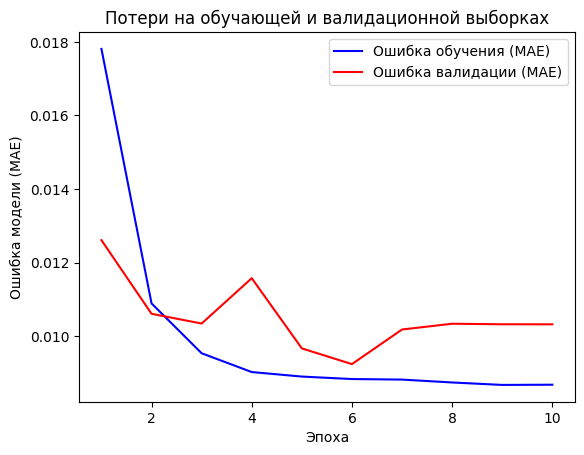

In [ ]:
# График обучения
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(1,len(mae)+1)

plt.title('Потери на обучающей и валидационной выборках')
plt.plot(epochs,mae,color='blue',label='Ошибка обучения (MAE)')
plt.plot(epochs,val_mae,color='red',label='Ошибка валидации (MAE)')
plt.xlabel('Эпоха')
plt.ylabel('Ошибка модели (MAE)')
plt.legend()
plt.show()

In [ ]:
# Результаты работы модели
y_pred = model2LTMS.predict(X_test)
y_pred_inv = min_max_scaler.inverse_transform(y_pred)
y_test_inv = min_max_scaler.inverse_transform(y_test.reshape(-1,1))

from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error

print('R2 Score (Test) = ',round(r2_score(y_true=y_test_inv,y_pred=y_pred_inv),3))
print('MAE (Test) = ',round(mean_absolute_error(y_true=y_test_inv,
                                                     y_pred=y_pred_inv),3), 'C')
print('MSE (Test) = ', round(mean_squared_error(y_true=y_test_inv, y_pred=y_pred_inv), 3))

561/561 [==============================] - 3s 6ms/step
R2 Score (Test) =  0.995
MAE (Test) =  0.814 C
MSE (Test) =  1.161


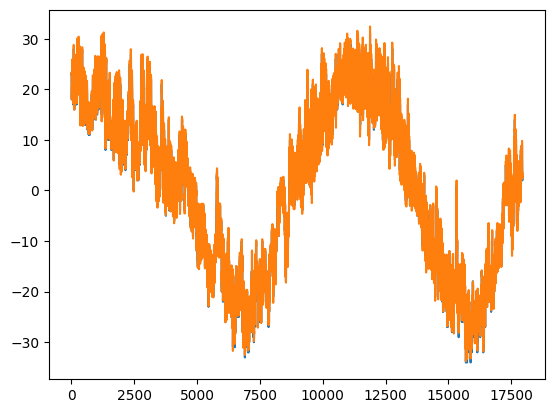

In [ ]:
# Наложенные графики для сравнения
plt.plot(range(1,len(y_test_inv)+1),y_test_inv)
plt.plot(range(1,len(y_pred_inv)+1),y_pred_inv)